In [1]:
import pandas as pd
import os
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

# LeNet5 Train

In [4]:
os.getcwd()
LENET5 = "runs/LeNet5"

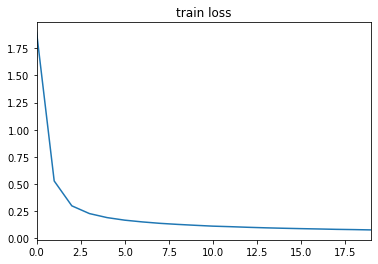

In [5]:
path = os.path.join(LENET5, "train_logs.xlsx")
df = pd.read_excel(path, index_col=0)
df['train loss'].plot(title='train loss')

# LeNet5 Test
## MNIST

In [8]:
MNIST_DF = "runs/LeNet5/mnist_test.xlsx"

# load xlsx
df = pd.read_excel(MNIST_DF)

# accuracy
right_preds = df[df.prediction_ok == True]
print("Test accuracy: ", len(right_preds) / df.shape[0])

TypeError: unsupported operand type(s) for /: 'int' and 'method'

## NOT-MNIST